## Importing necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

<br><br>

## Load the stock dataset from CSV file

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/DATA.csv')
df.head()

,Date,Open,High,Low,Close,Volume,NASDAQ,NYSE,S&P 500,FTSE100,...,RUSSELL2000,HENG SENG,SSE,Crude Oil,Gold,VIX,USD index,Amazon,Google,Microsoft
0,7/2/2010,8.946072,8.961785,8.685715,8.819285,693842800,2091.790039,6434.810059,1022.580017,4838.09,...,598.969971,19905.32031,2382.900879,72.139999,1207.400024,30.120001,84.43,109.139999,109.139999,23.270000
1,7/1/2010,9.082143,9.100000,8.686429,8.874286,1022896000,2101.360107,6462.029785,1027.369995,4805.75,...,604.760010,NaN,2373.791992,72.949997,1206.300049,32.860001,84.72,110.959999,110.959999,23.160000
2,7/6/2010,8.964286,9.028571,8.791429,8.879642,615235600,2093.879883,6486.089844,1028.060059,4965.00,...,590.030029,20084.11914,2409.424072,71.980003,1194.800049,29.650000,84.08,110.059998,110.059998,23.820000
3,7/7/2010,8.946072,9.241786,8.919642,9.238214,654556000,2159.469971,6685.779785,1060.270020,5014.82,...,611.659973,19857.07031,2421.116943,74.070000,1198.599976,26.840000,83.82,113.430000,113.430000,24.299999
4,7/8/2010,9.374286,9.389286,9.103214,9.217500,738144400,2175.399902,6755.810059,1070.250000,5105.45,...,620.270020,20050.56055,2415.149902,75.440002,1195.800049,25.709999,83.82,116.220001,116.220001,24.410000


<br><br>

## Data Preprocessing

In [ ]:
# Checking for missing values in each column
missing_data = df.isnull().sum()
missing_data

Date             0
Open             0
High             0
Low              0
Close            0
Volume           0
NASDAQ           0
NYSE             0
S&P 500          0
FTSE100          3
NIKKI225       134
BSE SENSEX     127
RUSSELL2000      0
HENG SENG      112
SSE            170
Crude Oil        2
Gold             2
VIX              0
USD index        0
Amazon           0
Google           0
Microsoft        0
dtype: int64

In [ ]:
# drop rows with missing values
df.dropna(inplace=True)

In [ ]:
# Rename the column names
df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'NASDAQ', 'NYSE', 'S&P 500', 'FTSE100', 'NIKKI225', 'BSE SENSEX', 'RUSSELL2000', 'HENG SENG', 'SSE', 'Crude Oil', 'Gold', 'VIX', 'USD index', 'Amazon', 'Google', 'Microsoft']

In [ ]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Sort the DataFrame by the 'Date' column in ascending order
df.sort_values(by='Date', ascending=True, inplace=True)

In [ ]:
df.head()

,Date,Open,High,Low,Close,Volume,NASDAQ,NYSE,S&P 500,FTSE100,...,RUSSELL2000,HENG SENG,SSE,Crude Oil,Gold,VIX,USD index,Amazon,Google,Microsoft
0,2010-07-02,8.946072,8.961785,8.685715,8.819285,693842800,2091.790039,6434.810059,1022.580017,4838.09,...,598.969971,19905.32031,2382.900879,72.139999,1207.400024,30.120001,84.43,109.139999,109.139999,23.270000
2,2010-07-06,8.964286,9.028571,8.791429,8.879642,615235600,2093.879883,6486.089844,1028.060059,4965.00,...,590.030029,20084.11914,2409.424072,71.980003,1194.800049,29.650000,84.08,110.059998,110.059998,23.820000
3,2010-07-07,8.946072,9.241786,8.919642,9.238214,654556000,2159.469971,6685.779785,1060.270020,5014.82,...,611.659973,19857.07031,2421.116943,74.070000,1198.599976,26.840000,83.82,113.430000,113.430000,24.299999
4,2010-07-08,9.374286,9.389286,9.103214,9.217500,738144400,2175.399902,6755.810059,1070.250000,5105.45,...,620.270020,20050.56055,2415.149902,75.440002,1195.800049,25.709999,83.82,116.220001,116.220001,24.410000
5,2010-07-09,9.174643,9.282143,9.112857,9.272142,433322400,2196.449951,6808.709961,1077.959961,5132.94,...,629.429993,20378.66016,2470.923096,76.089996,1209.599976,24.980000,83.95,117.260002,117.260002,24.270000


In [ ]:
data = df

In [ ]:
# Extract 'Gold' prices
prices = data['Gold'].values.astype(float)

In [ ]:
# Normalize data to scale values between 0 and 1
scaler = MinMaxScaler()
prices_scaled = scaler.fit_transform(prices.reshape(-1, 1))

<br><br>

## Model Training

In [ ]:
# Define a function to create sequences for LSTM
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequence = data[i:i+sequence_length]
        sequences.append(sequence)
    return np.array(sequences)

# Choose the sequence length (e.g., 10 days)
sequence_length = 10

# Create sequences for LSTM
sequences = create_sequences(prices_scaled, sequence_length)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sequences[:, :-1], sequences[:, -1], test_size=0.2, random_state=42)

In [ ]:
model = Sequential()

# Add an LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length - 1, 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
52/52 [==============================] - 5s 12ms/step - loss: 0.0583
Epoch 2/50
52/52 [==============================] - 1s 12ms/step - loss: 0.0060
Epoch 3/50
52/52 [==============================] - 1s 15ms/step - loss: 0.0058
Epoch 4/50
52/52 [==============================] - 1s 20ms/step - loss: 0.0058
Epoch 5/50
52/52 [==============================] - 1s 20ms/step - loss: 0.0058
Epoch 6/50
52/52 [==============================] - 1s 21ms/step - loss: 0.0057
Epoch 7/50
52/52 [==============================] - 1s 20ms/step - loss: 0.0056
Epoch 8/50
52/52 [==============================] - 1s 13ms/step - loss: 0.0058
Epoch 9/50
52/52 [==============================] - 1s 13ms/step - loss: 0.0056
Epoch 10/50
52/52 [==============================] - 1s 13ms/step - loss: 0.0057
Epoch 11/50
52/52 [==============================] - 1s 13ms/step - loss: 0.0057
Epoch 12/50
52/52 [==============================] - 1s 12ms/step - loss: 0.0056
Epoch 13/50
52/52 [==================

<br><br>

## Model Evaluation

In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Inverse transform the scaled predictions and actual values
y_pred_actual = scaler.inverse_transform(y_pred)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
r2 = r2_score(y_test_actual, y_pred_actual)
mse = mean_squared_error(y_test_actual, y_pred_actual)
mae = mean_absolute_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)

print(f"R-squared (R2): {r2}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


13/13 [==============================] - 2s 6ms/step
R-squared (R2): 0.753015822880087
Mean Squared Error (MSE): 11044.545326241523
Mean Absolute Error (MAE): 48.351640737255266
Root Mean Squared Error (RMSE): 105.09303176824581


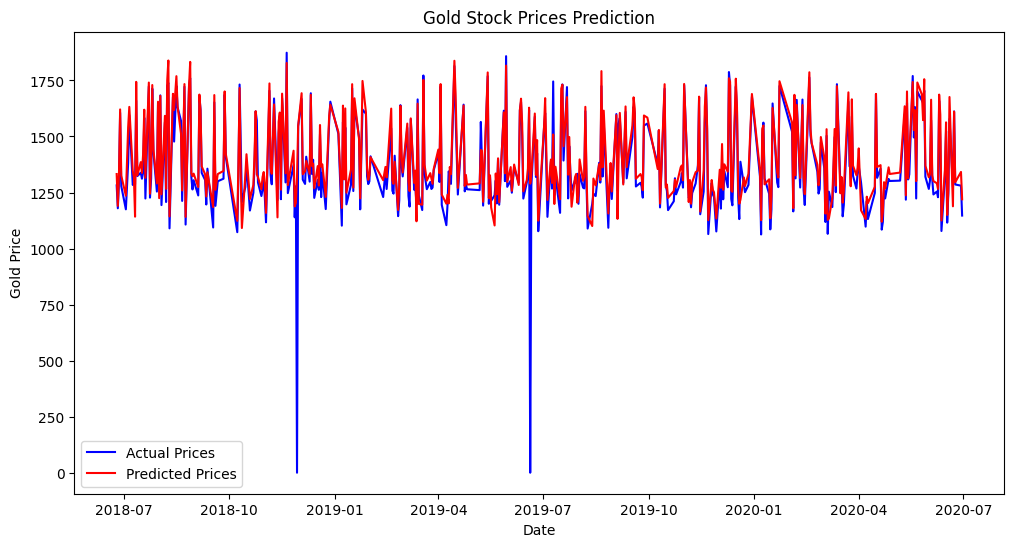

In [ ]:
# Extract dates for plotting
dates = data['Date'][-len(y_test):]

# Plot the actual and predicted prices
plt.figure(figsize=(12, 6))
plt.plot(dates, y_test_actual, label='Actual Prices', color='blue')
plt.plot(dates, y_pred_actual, label='Predicted Prices', color='red')
plt.title('Gold Stock Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.legend()
plt.show()


In [ ]:
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'NASDAQ', 'NYSE',
       'S&P 500', 'FTSE100', 'NIKKI225', 'BSE SENSEX', 'RUSSELL2000',
       'HENG SENG', 'SSE', 'Crude Oil', 'Gold', 'VIX', 'USD index', 'Amazon',
       'Google', 'Microsoft'],
      dtype='object')

13/13 [==============================] - 0s 4ms/step



Stock: NASDAQ
Mean Squared Error (MSE): 300348.39
Mean Absolute Error (MAE): 469.92
Root Mean Squared Error (RMSE): 548.04
R-squared (R2): 0.93


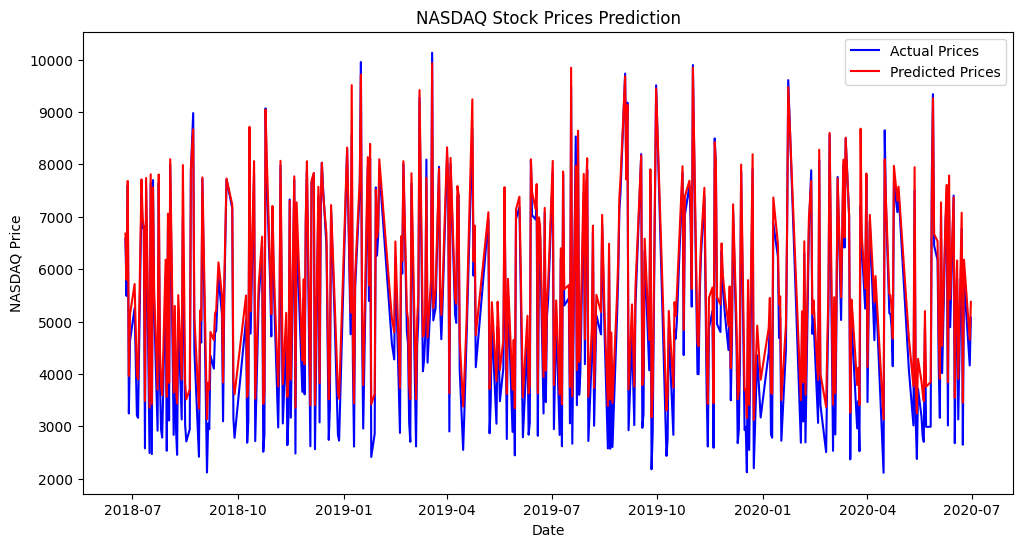

13/13 [==============================] - 0s 4ms/step



Stock: NYSE
Mean Squared Error (MSE): 198329.54
Mean Absolute Error (MAE): 339.32
Root Mean Squared Error (RMSE): 445.34
R-squared (R2): 0.94


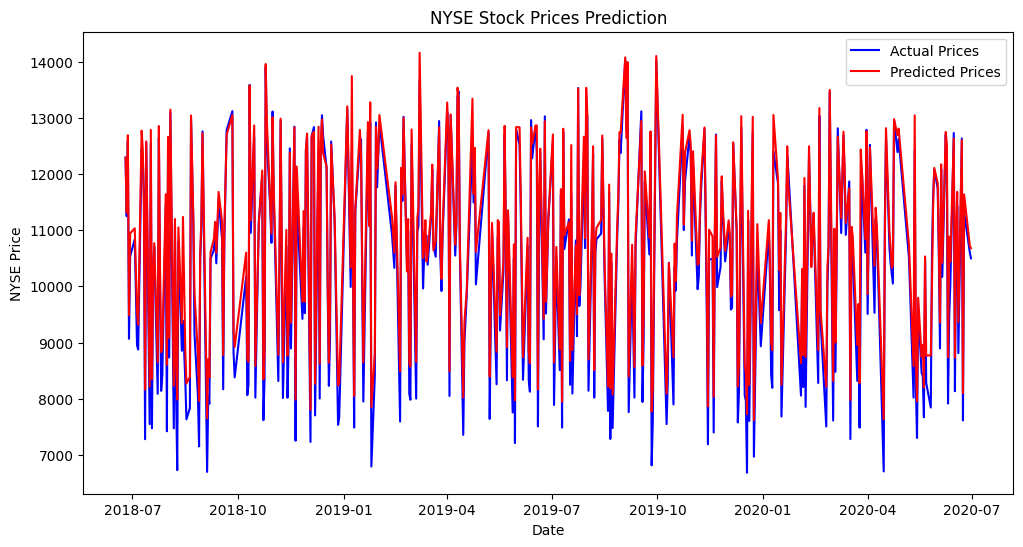

13/13 [==============================] - 0s 4ms/step



Stock: S&P 500
Mean Squared Error (MSE): 21043.48
Mean Absolute Error (MAE): 119.51
Root Mean Squared Error (RMSE): 145.06
R-squared (R2): 0.94


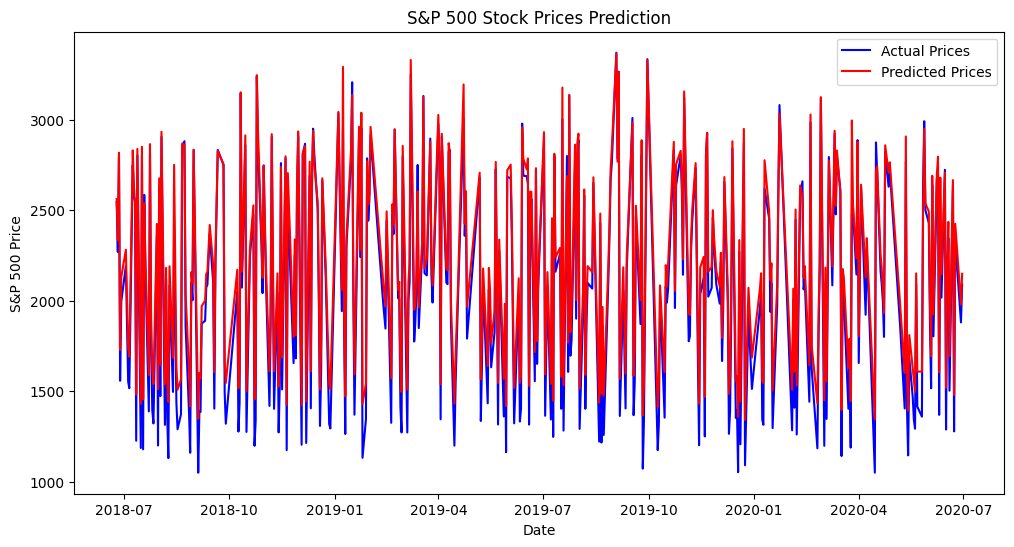

13/13 [==============================] - 0s 5ms/step



Stock: FTSE100
Mean Squared Error (MSE): 33506.37
Mean Absolute Error (MAE): 128.80
Root Mean Squared Error (RMSE): 183.05
R-squared (R2): 0.93


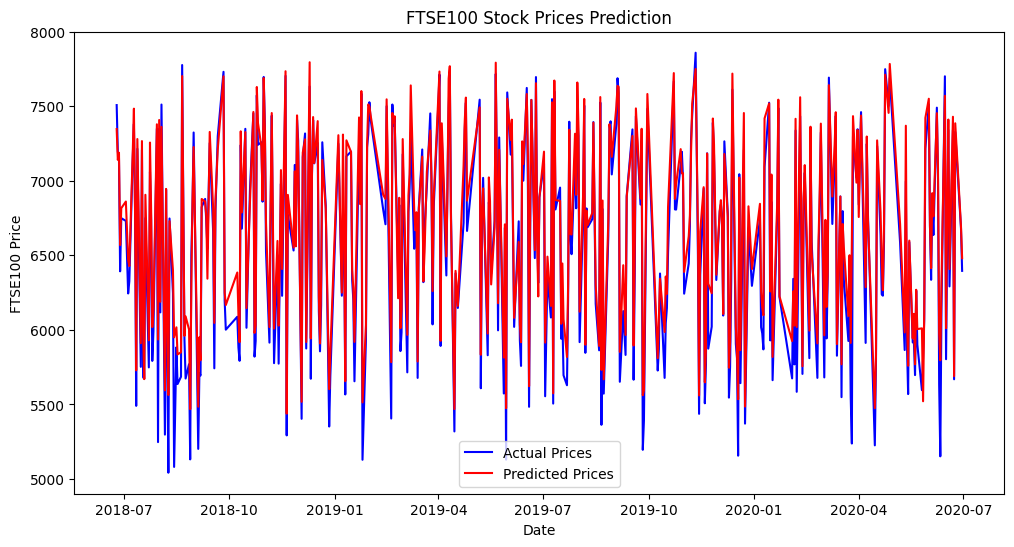

13/13 [==============================] - 0s 4ms/step



Stock: NIKKI225
Mean Squared Error (MSE): 8393425.37
Mean Absolute Error (MAE): 1094.76
Root Mean Squared Error (RMSE): 2897.14
R-squared (R2): 0.71


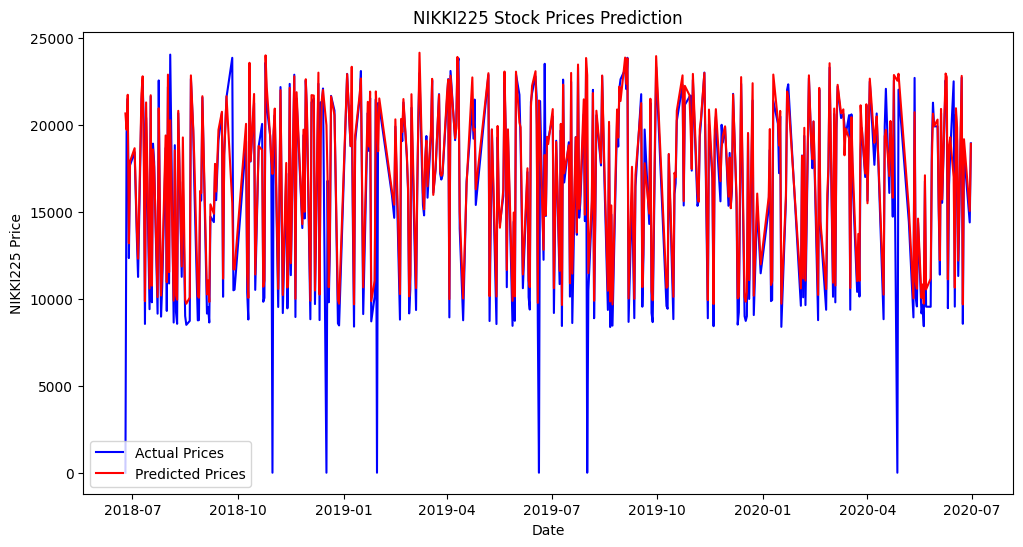

13/13 [==============================] - 0s 6ms/step



Stock: BSE SENSEX
Mean Squared Error (MSE): 1907967.60
Mean Absolute Error (MAE): 1141.67
Root Mean Squared Error (RMSE): 1381.29
R-squared (R2): 0.96


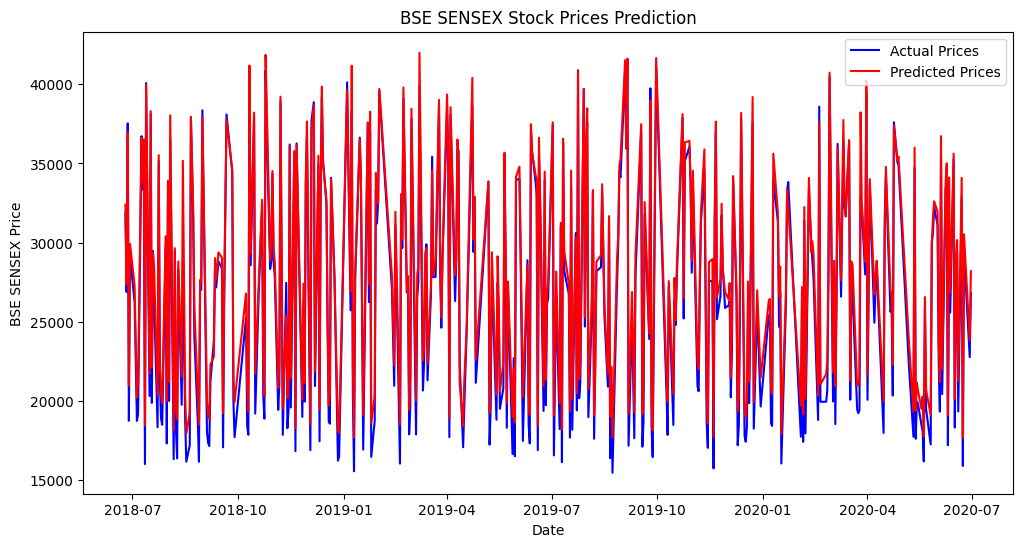

13/13 [==============================] - 0s 5ms/step



Stock: RUSSELL2000
Mean Squared Error (MSE): 4673.83
Mean Absolute Error (MAE): 53.58
Root Mean Squared Error (RMSE): 68.37
R-squared (R2): 0.95


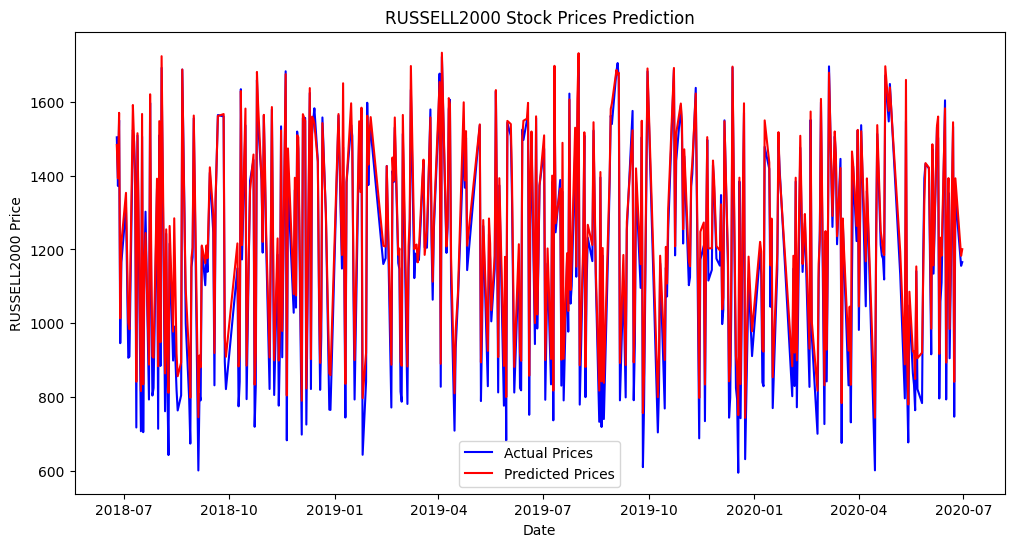

13/13 [==============================] - 0s 5ms/step



Stock: HENG SENG
Mean Squared Error (MSE): 2169959.20
Mean Absolute Error (MAE): 763.00
Root Mean Squared Error (RMSE): 1473.08
R-squared (R2): 0.82


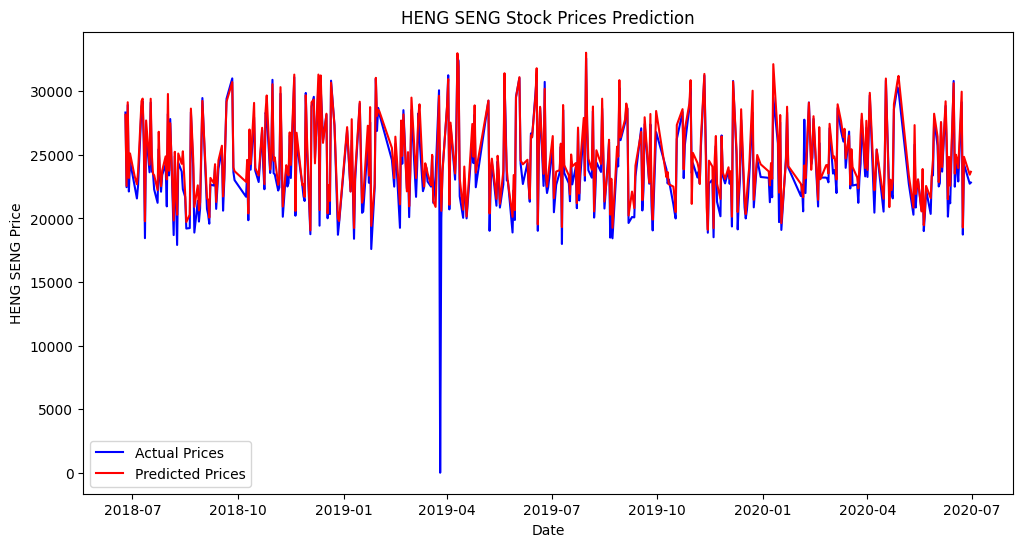

13/13 [==============================] - 0s 5ms/step



Stock: SSE
Mean Squared Error (MSE): 34700.76
Mean Absolute Error (MAE): 168.93
Root Mean Squared Error (RMSE): 186.28
R-squared (R2): 0.87


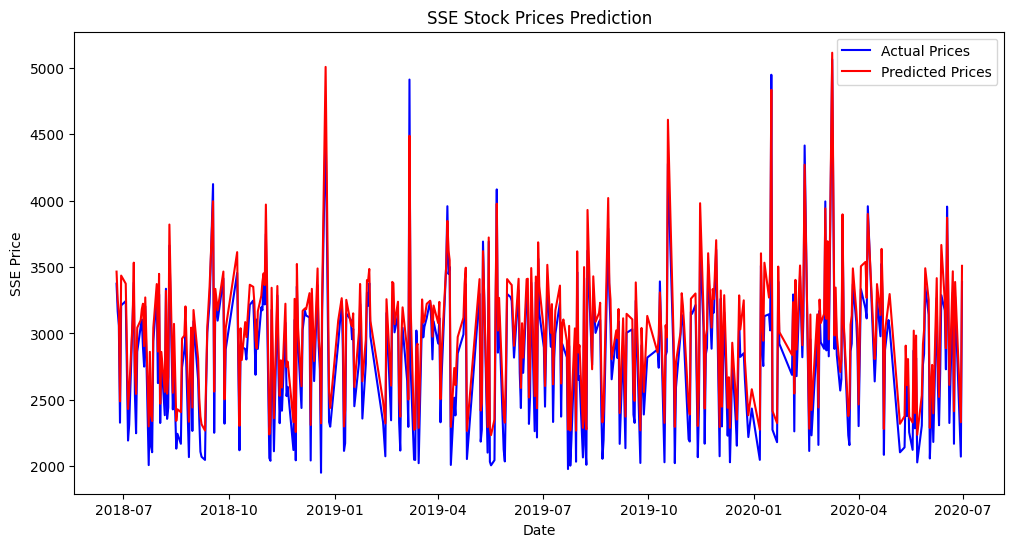

13/13 [==============================] - 0s 6ms/step



Stock: Crude Oil
Mean Squared Error (MSE): 36.64
Mean Absolute Error (MAE): 3.99
Root Mean Squared Error (RMSE): 6.05
R-squared (R2): 0.94


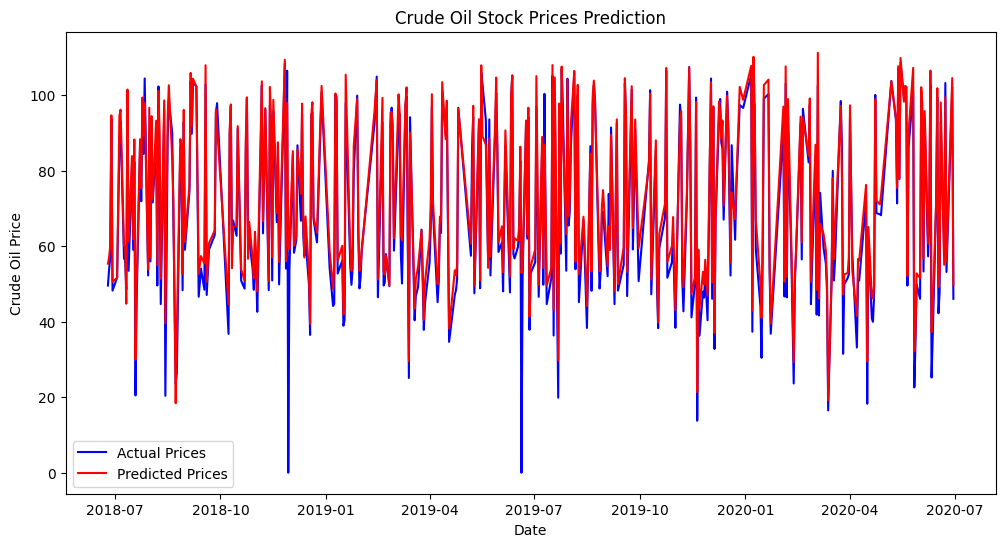

13/13 [==============================] - 0s 5ms/step



Stock: Gold
Mean Squared Error (MSE): 11044.55
Mean Absolute Error (MAE): 48.35
Root Mean Squared Error (RMSE): 105.09
R-squared (R2): 0.75


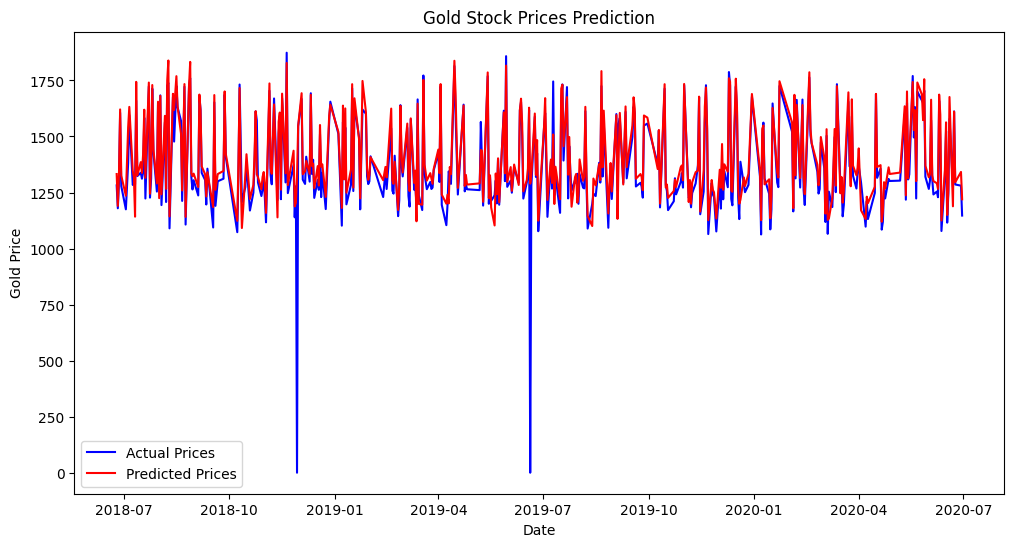

13/13 [==============================] - 0s 6ms/step



Stock: VIX
Mean Squared Error (MSE): 62.90
Mean Absolute Error (MAE): 7.52
Root Mean Squared Error (RMSE): 7.93
R-squared (R2): 0.13


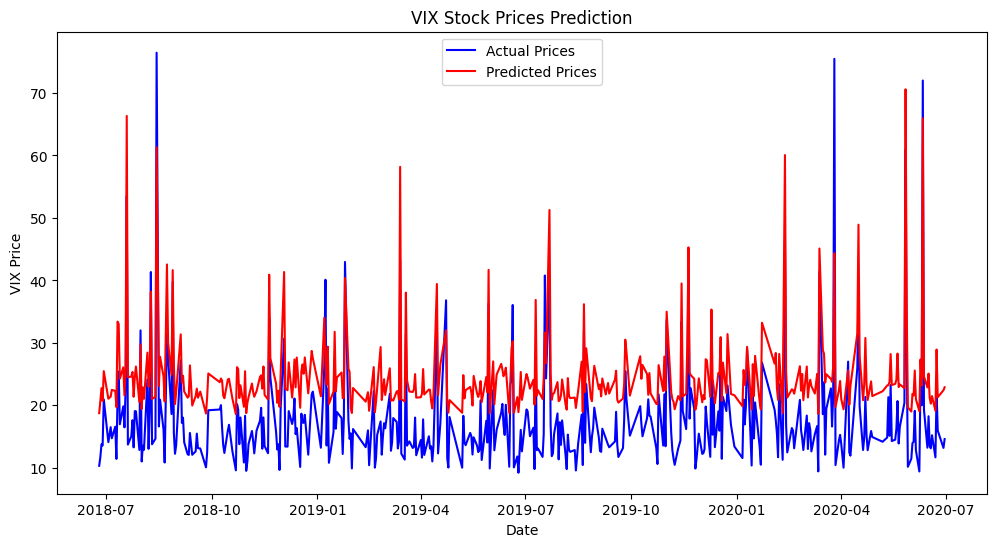

13/13 [==============================] - 0s 6ms/step



Stock: USD index
Mean Squared Error (MSE): 2.69
Mean Absolute Error (MAE): 1.32
Root Mean Squared Error (RMSE): 1.64
R-squared (R2): 0.96


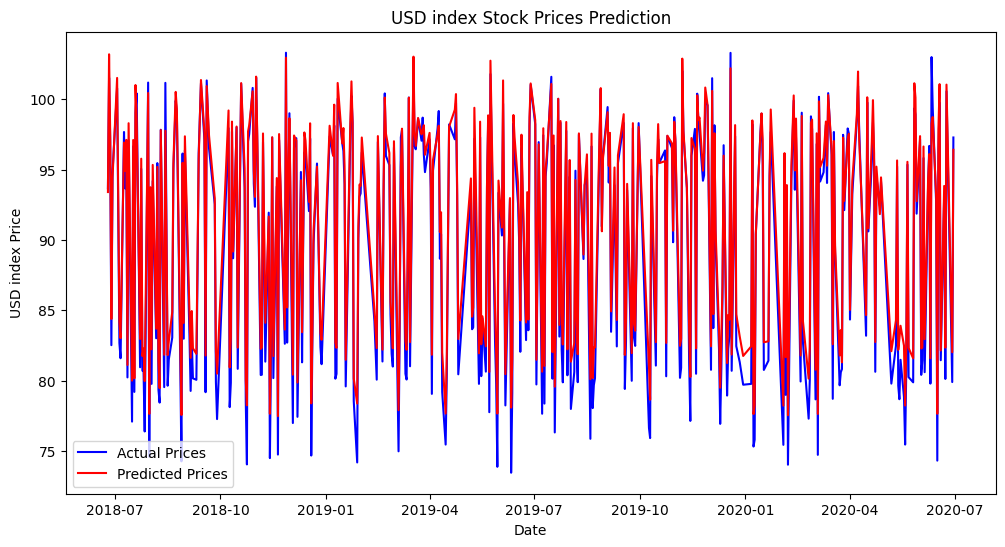

13/13 [==============================] - 0s 7ms/step



Stock: Amazon
Mean Squared Error (MSE): 50730.15
Mean Absolute Error (MAE): 201.99
Root Mean Squared Error (RMSE): 225.23
R-squared (R2): 0.88


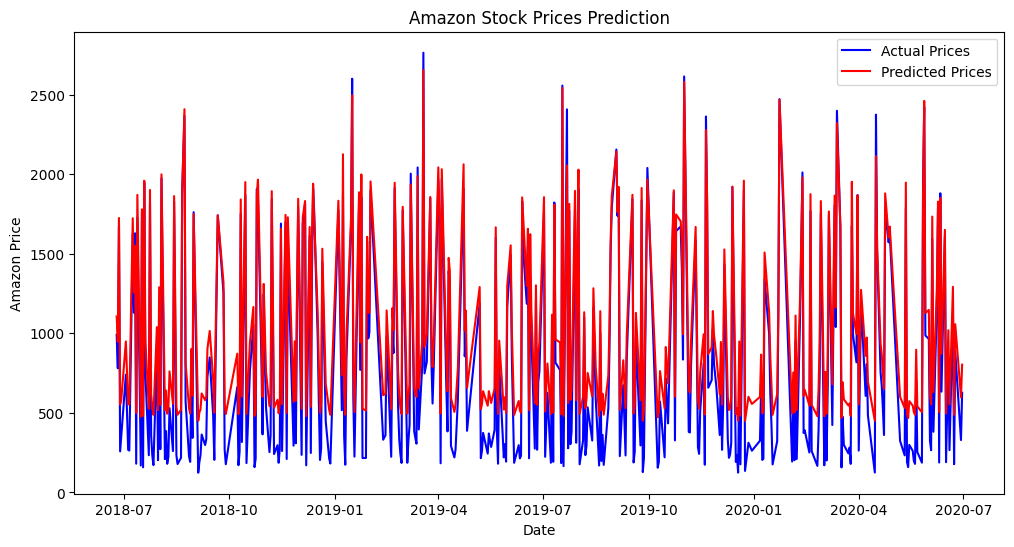

13/13 [==============================] - 0s 7ms/step



Stock: Google
Mean Squared Error (MSE): 50730.15
Mean Absolute Error (MAE): 201.99
Root Mean Squared Error (RMSE): 225.23
R-squared (R2): 0.88


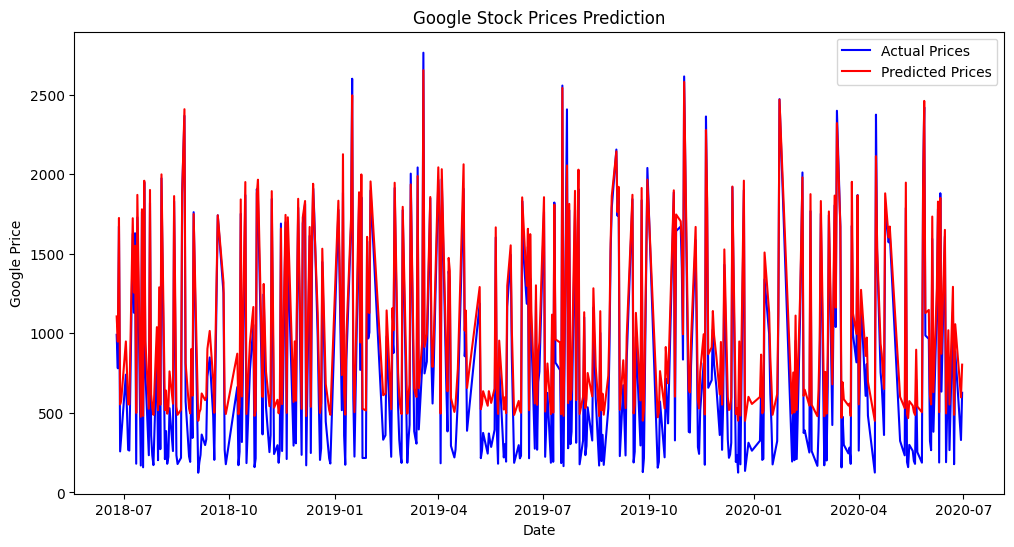

13/13 [==============================] - 0s 6ms/step



Stock: Microsoft
Mean Squared Error (MSE): 252.43
Mean Absolute Error (MAE): 14.56
Root Mean Squared Error (RMSE): 15.89
R-squared (R2): 0.86


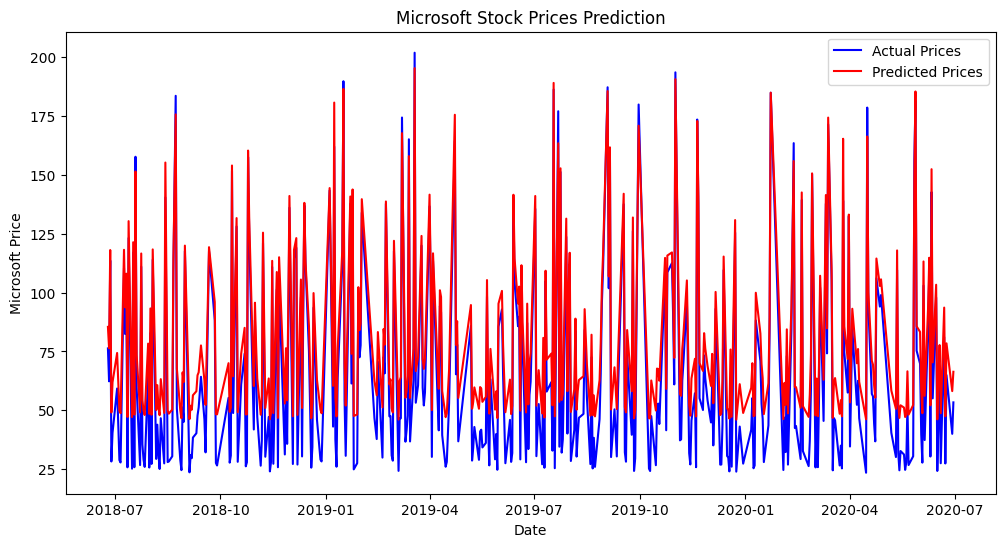

In [ ]:
# List of stock assets to predict (e.g., 'Gold', 'Amazon', 'Google', etc.)
assets_to_predict = ['NASDAQ', 'NYSE', 'S&P 500', 'FTSE100', 'NIKKI225', 'BSE SENSEX', 'RUSSELL2000', 'HENG SENG', 'SSE', 'Crude Oil', 'Gold', 'VIX', 'USD index', 'Amazon', 'Google', 'Microsoft']  # Add more assets as needed

# Loop through each asset
for asset in assets_to_predict:
    # Extract 'Gold' prices
    prices = data[asset].values.astype(float)

    # Normalize data to scale values between 0 and 1
    scaler = MinMaxScaler()
    prices_scaled = scaler.fit_transform(prices.reshape(-1, 1))

    # Choose the sequence length (e.g., 10 days)
    sequence_length = 10

    # Create sequences for LSTM
    sequences = create_sequences(prices_scaled, sequence_length)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(sequences[:, :-1], sequences[:, -1], test_size=0.2, random_state=42)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Inverse transform the scaled predictions and actual values
    y_pred_actual = scaler.inverse_transform(y_pred)
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calculate metrics
    r2 = r2_score(y_test_actual, y_pred_actual)
    mse = mean_squared_error(y_test_actual, y_pred_actual)
    mae = mean_absolute_error(y_test_actual, y_pred_actual)
    rmse = np.sqrt(mse)

    print(f"\n\n\nStock: {asset}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R-squared (R2): {r2:.2f}")

    # Extract dates for plotting
    dates = data['Date'][-len(y_test):]

    # Plot the actual and predicted prices
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_test_actual, label='Actual Prices', color='blue')
    plt.plot(dates, y_pred_actual, label='Predicted Prices', color='red')
    plt.title(f'{asset} Stock Prices Prediction')
    plt.xlabel('Date')
    plt.ylabel(f'{asset} Price')
    plt.legend()
    plt.show()
